# Customer review timeline (of Sea Temple Port Douglas)

I'm traveling thoughout Australia with a WH visa. I wanted to apply for a extention to my visa. Then, to do so, I have to work either in hospitality or farm for 88 days north of the tropic. I have experience in both farms (picking fruit in New Zealand in a WH as weell) and tourism (in Chile), but this is not New Zealand, here theres is lots of deadly animals everywhere, so a prefer to work inside a Resort rather than in the field. So, I moved to Port Douglas, a very touristic spot.

The work is nice as housekeeper, but I miss my analytics. Of course, before I came I had wanted to know who is who in this touristic hub in northen Queensland, which is close to the Daintree rainfores and one of the best spots to see the gigant coral reef. 

I knew the major players and I checked their commentaries in TripAdvisor. Later, talking to one of the supervisors about customer reviews, I been taught the metrics of quality they hold. It seems none of the metrics considered the text -which is my specialization- to build a systematic review though time (I mean, they read thoughtfully the comments and have some insights how comments vary through time, but not a systematic indicator, let say a number over text or some other pattern more interesting).

I think it is time to apply some analytics to text review the TripAvisor reviews. I updated my webscrapping scrit to get the data (1880 english reviews) and is time to play.


In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as plt
plt.rcParams["figure.figsize"] = [15, 7]
import scipy.stats as stats
from __future__ import unicode_literals
plt.style.use(['dark_background'])

In [2]:
data = pd.read_csv('C:/Users/Cami/Google Drive/Python/Pullman/tripullman/test.csv', encoding= "utf-8")
#C:\Users\Cami\Google Drive\Python\Pullman\tripullman


In [3]:
data.shape

(1880, 16)

In [4]:
data.columns

Index([u'N_opinion', u'Nivel', u'Op_sobre', u'autor', u'califica',
       u'calificacion', u'comentario', u'direccion', u'fecha', u'lugar',
       u'nombre', u'region', u'tipo', u'tipo1', u'titulo', u'web'],
      dtype='object')

In [5]:
data.califica = data.califica/10

## How califications distribute

TripAdvisor has a system of bubbles (or Stars) ranking from 1 to 5. In that respect, most reviews give 5 bubbles to the resort with more than 1000 high score reviews (more than half of reviews).

In [6]:
data.califica.describe()

count    1880.000000
mean        4.261170
std         0.986002
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: califica, dtype: float64

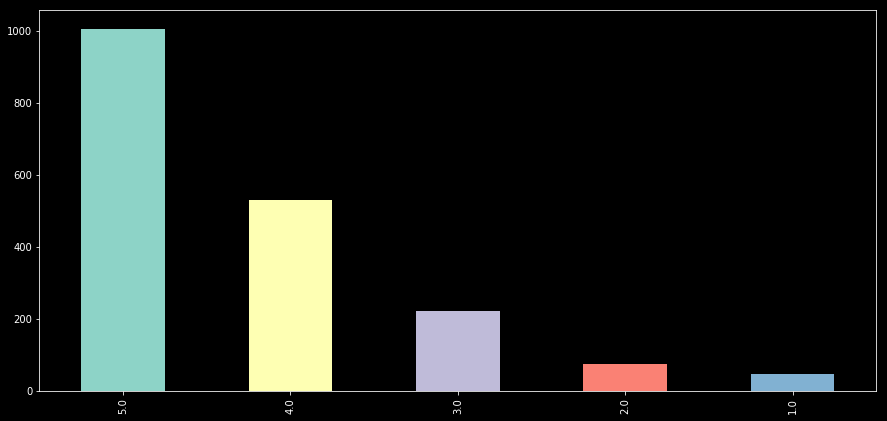

In [7]:
data.califica.value_counts().plot(kind='bar')

## Timeseries
 
First I should see how many commentaries the resort has monthly.

In [8]:
data['fecha2'] = pd.to_datetime(data.fecha,format='%d %B %Y')


In [9]:
dfd = data.copy()
dfd.index = dfd['fecha2']
dfd.index = pd.to_datetime(dfd.index)
dfd = dfd.sort_values('fecha2')

C:\Users\Cami\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'fecha2' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  after removing the cwd from sys.path.


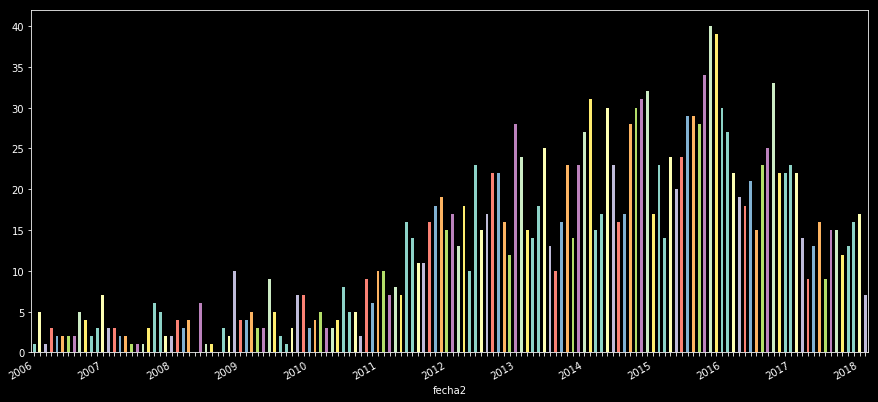

In [10]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

barra=dfd.califica.copy()
barra=barra.resample(rule='M').count()
ax = barra.plot(kind='bar', x=barra.index)

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(barra.index)
# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%Y') for item in barra.index[::12]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

plt.pyplot.gcf().autofmt_xdate()
plt.pyplot.show()

OK. So since 2012 comments are 20 each month, reaching a pick in 2017 up to 40 comments in a single month.

### Calification through time

Let's calculate the calification mean of every month.

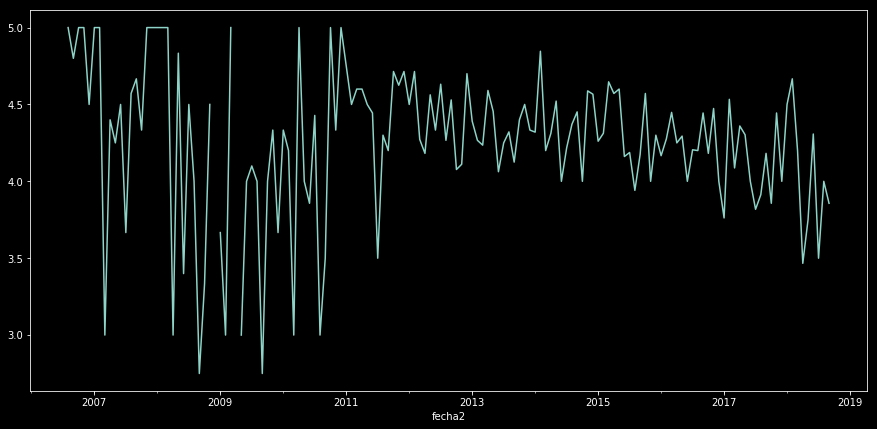

In [11]:
linea=dfd.califica.copy()
linea=linea.resample(rule='M').mean()
linea.plot(kind='line')

It seems that before 2012 -when there is few comments- the mean looks volatile, but then moves aroud 4.5 and its been slighly decreasing. More stable version could be the accumulate version.

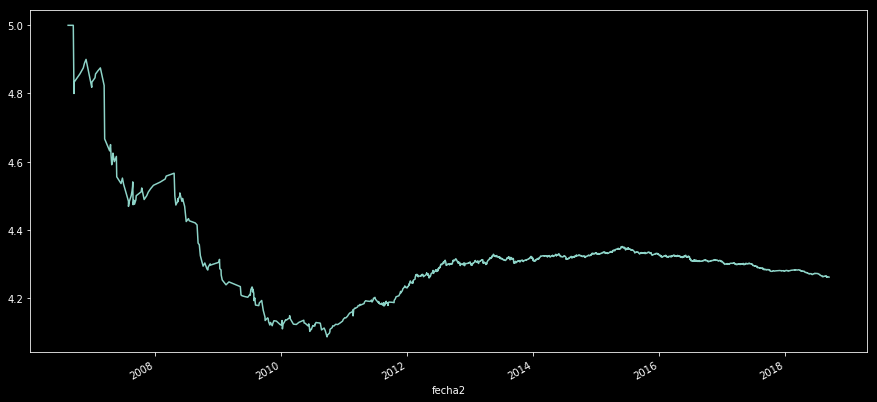

In [12]:
lineaAccum=dfd.califica.copy()
lineaAccum=lineaAccum.expanding().mean()
lineaAccum.plot(kind='line')

Mean becomes more stable as more reviews are added, so to change a reputation over time requires a lots of comments of oposite sign. It means that the initial good reputation was easely lower at the begining by few bad comments but then reverse easely as well. But then, when it reachs a plateau, change are more subtle. So the slighly deacrease in the end could hide something.

Let's see the distribution of reviews throught time if we normalize by the amount of reviews. Just take data  from 2014 and on to take the initial noise out.

C:\Users\Cami\Anaconda2\lib\site-packages\pandas\core\reshape\pivot.py:86: FutureWarning: 'fecha2' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys, observed=False)


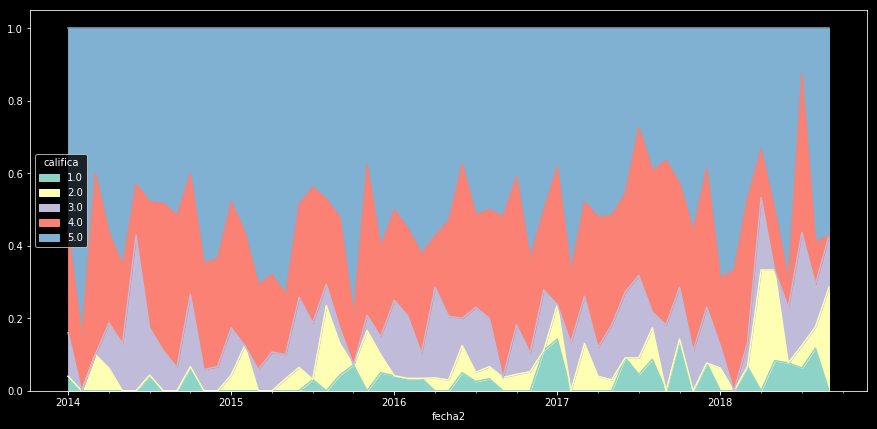

In [13]:
calification=pd.crosstab(dfd.fecha2,dfd.califica)
calification=calification.resample(rule='M').sum()
calification['total']=calification.sum(axis=1) # calculate a horizontal sum as total
calification=calification.div(calification.total,0) # divide each column again total column
calification=calification.drop('total',1) #erase total column
#calification=pd.concat([calification], keys=calification.index.year, names=['ano'])
calification.loc['2014':,:].plot(kind='area')
#calification.head()

It seems that the last year scores lower than 3 are more common than before. What if we compare year after year.

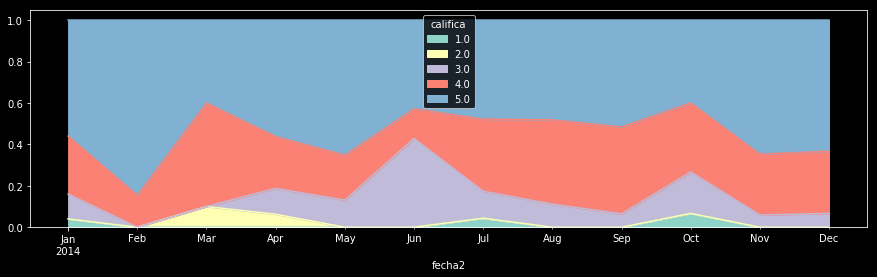

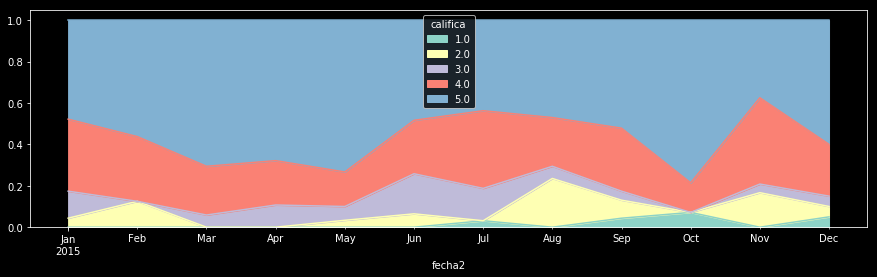

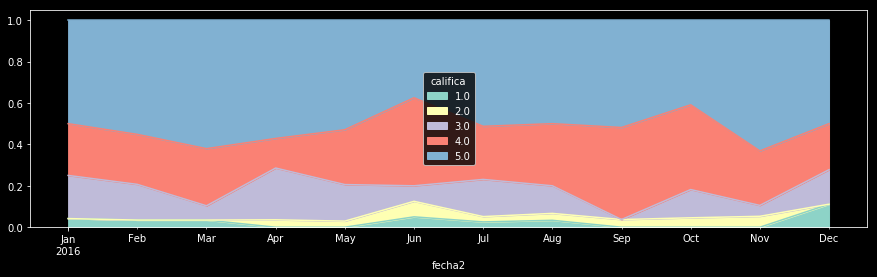

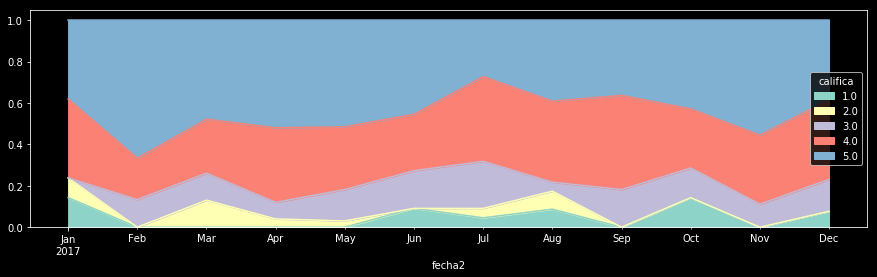

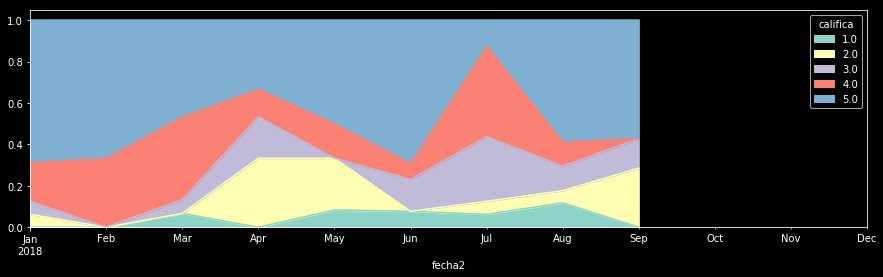

In [14]:
years = map(str, calification.index.year.unique()[8:].tolist())
for year, i in zip(years[:-1], range(len(years)-1)):
    calification.loc[year:year,:].plot(kind='area',figsize=(15,4),sharex=True)
calification.loc['2018':'2018',:].plot(kind='area',figsize=(15,4),xlim=(pd.Timestamp('2018-01-31 00:00:00', tz=None),pd.Timestamp('2018-12-01 00:00:00', tz=None)))

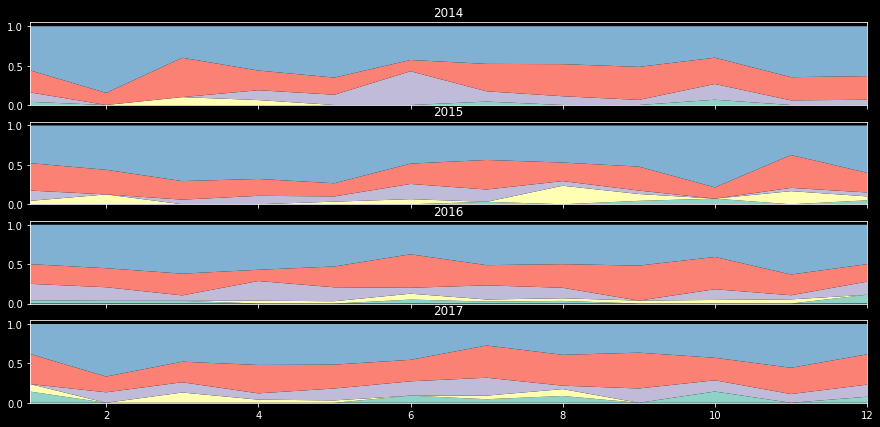

In [231]:
from matplotlib import dates
fig, ax = plt.pyplot.subplots(4, 1, sharex='col', sharey='row')
years = map(str, calification.index.year.unique()[8:].tolist())
x_dates = calification.index.month.sort_values().unique()
for year, i in zip(years[:-1], range(len(years)-1)):
    c=calification.loc[year:year,:]
    ax[i].stackplot(c.index.month,c[c.columns[0]],c[c.columns[1]],c[c.columns[2]],c[c.columns[3]],c[c.columns[4]])
    #ax[i].xaxis_date()
    #ax[i].xaxis.set_major_formatter(plt.pyplot.FixedFormatter(x_dates))
    #ax[i].xaxis.set_major_formatter(dates.DateFormatter('\n%b'))
    ax[i].set_xlim(1,12)
    ax[i].set_title(year)
    #ax[i].
    


Well, at least until september there is heaps more negatives comments. Something not good is happening.

## The Comments

Despite previus observation, many reviews are generally positive, but they refer to different things. To make things clearer let's split the reviews into sentences. That way we could note the diference if a comment is about more than one subject.

### Prepare text data and split reviews into sentences

In [15]:
from nltk.tokenize import word_tokenize, sent_tokenize
dm = data[['titulo','califica','comentario','fecha']].copy()
dm.dropna(inplace=True)
dm['sent']=dm.comentario.apply(sent_tokenize)
dm2= (dm['sent'].apply(lambda x: pd.Series(x)).stack().reset_index(level=1, drop=True).to_frame('sent').join(dm[['titulo','califica','comentario','fecha']], how='left'))

Check the new data set with a sentence by row.

In [16]:
dm3=dm2.reset_index().copy()
dm3.head()

,index,sent,titulo,califica,comentario,fecha
0,0,5 star prices and 3 star service.,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
1,0,We stayed in a villa with a private pool which...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
2,0,The maintenance man even said it’s so hard to ...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
3,0,The food is bang average not just at the hotel...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018
4,0,The staff are all great and try and make your ...,First family holiday,3.0,5 star prices and 3 star service. We stayed in...,14 September 2018


## Look for meaning (most significative bi-grams)

#### Extract most common bi-grams and tri-grams

To explore the content fisrt I could have a look of the most frequent words. A simple model of sklearn can give us that information. Lets see some bi-grams and tri-grams.

In [17]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

stp = nltk.corpus.stopwords.words('English') 
dm3.sent.dropna(inplace=True)

vectorizer = TfidfVectorizer(lowercase=True, stop_words=stp[:130] ,ngram_range = (2,3), min_df=5).fit(dm3.sent)
full_matrix = vectorizer.transform(dm3.sent)


C:\Users\Cami\Anaconda2\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [18]:
def display_scores(vectorizer, tfidf_result,n=50):
    # http://stackoverflow.com/questions/16078015/
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(tfidf_result.sum(axis=0)).ravel())
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    for item in sorted_scores[:n]:
        print "{0:50} Score: {1}".format(item[0], item[1])
        
display_scores(vectorizer,full_matrix,25)

sea temple                                         Score: 190.067955653
port douglas                                       Score: 185.099387049
pool bar                                           Score: 69.8731412815
staff friendly                                     Score: 65.5200786592
stayed nights                                      Score: 52.0425385122
room service                                       Score: 51.139810416
pool area                                          Score: 48.8863670619
lagoon pool                                        Score: 44.7722620339
front desk                                         Score: 43.8886533548
golf course                                        Score: 42.389832746
plunge pool                                        Score: 41.6875407997
friendly helpful                                   Score: 38.6354335457
two bedroom                                        Score: 36.1964953103
swimming pool                                      Score: 35.10498

This is the most frequent combinations of words in the reviews. It doesn't seem to be very meanful. But we can collect some insights. So, besides the name of the resort, the pool and the staff are defenly the most common words (and let me tell you, the pool is upstanding), must be very important part of customer experience. Let's try another techniques to get more information.

### Detect keyphases

We can improve the detection of n-grams. It not only will help to create keyphases to identify the text but also will improve the understanding of the text itself.

##### Keyphrases with bigrams

In [21]:
import nltk
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from collections import Counter

data_words = [i for i in dm3.sent]
#data_words = dm3.sent.apply(word_tokenize)
data_words = [simple_preprocess(i,deacc=True) for i in data_words]
# Build the bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


Now we check how one sentence looks once we created the n-grams.

In [22]:
print(trigram_mod[bigram_mod[data_words[632]]])

[u'me', u'and', u'my', u'husband', u'visited', u'port_douglas', u'for', u'short', u'stay', u'and', u'booked', u'an', u'accomodation', u'at', u'pullman', u'sea_temple', u'port_douglas']


Seems to work. Now I can clean the sentences and apply the ngram model it to the whole corpus.

In [24]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stp] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

text=remove_stopwords(data_words)
text=make_bigrams(text)
text=make_trigrams(text)

In [25]:
dm3.sent = text
dm3.sent = dm3.sent.apply(' '.join)

Since we have some "new words" created on n-grams lets try to check if I can create some keyphases. For that I will use word2Vec or word embeddings, that in theory would help to find synonymous to those phrases.

In [23]:
from gensim.models import Word2Vec

bigram_model = Word2Vec(bigram_mod[data_words], size=100)
bigram_model_counter = Counter()
for key in bigram_model.wv.vocab.keys():
    if key not in stp:
        if len(key.split("_")) > 1:
            bigram_model_counter[key] += bigram_model.wv.vocab[key].count

In [24]:
for key, counts in bigram_model_counter.most_common(30):
    print '{0: <20} {1}'.format(key.encode("utf-8"), counts)

sea_temple           523
port_douglas         512
front_desk           74
golf_course          67
highly_recommend     56
roof_top             56
shuttle_bus          52
well_appointed       47
hot_tub              40
direct_access        35
ground_floor         34
barrier_reef         30
mile_beach           29
school_holidays      29
wedding_anniversary  28
five_star            26
palm_cove            26
hire_car             25
minute_drive         24
four_mile            23
ended_up             22
washer_dryer         21
spiral_staircase     21
ve_ever              20
main_street          20
per_person           19
young_children       19
make_sure            19
self_contained       18
washing_machine      18


Now it looks like we can found some meaning on them. Let's check a couple interesting ones within context.

In [38]:
pd.set_option('display.max_colwidth', -1)
dm3[['sent','comentario']][dm3.sent.str.contains("front_desk")].sample(5)

,sent,comentario
6928,resort staff fantastic helpful front_desk staff checked us recommended booked reef tour housekeeping staff would happily work around schedule,"We stayed at the Sea Temple over Easter and were really impressed. We were upgraded to a enormous 2 bedroom, 2 bathroom penthouse, with a huge private rooftop terrace with jacuzzi and BBQ. The decor in the rooms was fresh and comfortable. We made full use of the kitchen facilities, BBQing each night. The pool is fantastic, it was great swimming at night under the stars. The resort was about a 10 min drive from Port Douglas, but it seemed most of the resorts were located out of town. The resort staff were fantastic, from the helpful front desk staff who checked us in and recommended an booked our reef tour to the housekeeping staff who would happily work around our schedule. Would definitely recommend the Sea Temple, we had a lovely stay."
6136,check last day front_desk let us leave luggage storage leave airport,"While this resort is beautiful there were several things that were less than acceptable. When we checked in we were told that our room was not ready as they were still cleaning. When we were given access to our room after being cleaned there were several wet, dirty pool towels on our patio. These towels remained there for three days even though I had let the front desk know that they were there. While we were there for 5 nights the WiFi did not work at all. This is unacceptable for a resort of this caliber. We were told daily that it would be up and running but this never did happen. Each day is was a different excuse. During our stay of December 26 through December 31 the resort was terribly understaffed and it took 10 to 15 minutes to get a drink poolside. There was only one bartender most of the day and he/she was running like crazy. In the morning there was only one barista and getting coffee took another 10 minutes or so. The barista was working the bar as well as the restaurant for breakfast. When the resort is booked they should staff accordingly. The work out room is extremely small for a resort of this size. There is not enough cardio equipment and the floor space is very tight. Almost impossible to get in a good work out. Each morning there was a wait for equipment and I saw a lot of people give up. Most guests have tours booked for the day and getting into the gym first thing in the morning is a must. When we had to check out on the last day the front desk let us leave our luggage in storage until we had to leave for the airport. We had to leave at 1:30 so stayed poolside for lunch. The poolside BBQ was to open at 12:00 but this is when they began setting up for the lunch. The gentleman working the BBQ was frazzled and stated that this what you get when you take a day off and they don't prep for the next day. You could not get anything to eat poolside until well after 1:00. This was unacceptable as we needed to eat and clean up prior to 1:30. We were going to clean up in the wash room off of the lobby. When we went to clean up the clothes that I had put in storage were missing. They searched the storage room and to no avail it was never found."
2510,ebony front_desk took time take us upgrade options asked showed us rooms also ensured customers waiting taken_care time,"We had a short time to unwind and relax and were absolutely delighted with the Pullman - our expectations were well exceeded. The service was a highlight. Ebony at front desk took time to take us through upgrade options we asked about, showed us through the rooms and also ensured other customers waiting were taken care of at the same time. We loved the changes we made and were delighted to experience extraordinary service from the moment we arrived - thank you Ebony! The team in the Aqua restaurant were also amazing with their genuine and flexible approach. A special shout out to Kat who's authentic and down to earth nature was refreshing. Kat you made us smile and took such great c

It seems that the guys at frond desk are doing a great job. 

In [39]:
dm3[['sent','comentario']][dm3.sent.str.contains("shuttle_bus")].sample(5)

,sent,comentario
3932,shuttle_bus runs every half hour port_douglas shops cost return,"What a stunning resort! It has an amazing pool that weaves itself throughout most of the apartments / rooms which allows direct access from your room straight into the pool . We however stayed in a 3br villa which came with our own private pool in our back garden ..... Absolute luxury and privacy!!! Our villa was enormous with ample room for our family of 4. The main bedroom even has 4 person spa in it .,.. However it took over 40 mins to fill it so we only used it once. A laundry area with a machine and dryer definately came in handy. A full kitchen ,an indoor fountain , desk area, 8 seater dining table and 4 couches were brilliant. Every with all this there was still a feeling of space . A beautiful experience staying here. Breakfast in the aqua restaurant was delicious and was lovely to sit near the pool and contemplate the day ahead. A shuttle bus runs every half an hour into port Douglas shops at the cost of $9 return. You could walk along the beach into town but it is a 40-60 minute walk. The pool bar served a small but satisfactory lunch menu . Overall an outstanding resort .... Any room here is incredible however I would check the resort map to choose your preferred room if you want sunshine or to be closer to reception. Some rooms do not get any afternoon sun."
6850,pt_douglas main_street minute_drive away resort shuttle_bus comes every minutes great get back forth dinner etc dont feel stuck resort whole time,"My husband and I came to stay at the Sea Temple Resort for a wedding. Upon arriving the staff were very friendly and personally drove us in the little buggy around to our room. We were staying in a Hotel Spa room, which was very nice and had a lovely big bathroom and view over the pool. Our friends had a two storey villa, which was AMAZING!!! The rooms were very nice - but try and get one that overlooks the pool. The resort itself is beautiful, very clean and was relatively quiet when we were there...very kid friendly as well. The buffet breakfast was ok, we recieved a discount as we were part of the wedding party, so only had to pay $20 rather then the normal $35 pp (which I think is far too overpriced) especially as it doesn't include espresso coffee (we had to pay extra for a latte). The pool bar is a nice touch, however a little overpriced and one day it wasn't even open. Pt Douglas main street is about a 7 minute drive away - the resort does have a shuttle bus that comes every 30 minutes, which was great to get back and forth for dinner etc; so you dont feel stuck in the resort the whole time. Overall we had a pleasant stay at the Sea temple. Only downfall would be their housekeeping staff, who often rushed and one day didn't restock any ammenities (no toilet paper, shampoo, soap etc;) I had to call reception to get some brought up to me. I would stay here again."
7518,hotel clean modern amenities would want hotel staff extremely helpful even upgraded room fantastic penthouse suite roof_terrace pool nice shuttle_bus town convenient made use,"We stayed in this hotel after much debate about other hotels to stay in this area and we are extremely glad we did. The hotel itself is very clean modern and had all of the amenities that you would want from a hotel, the staff were extremely helpful and even upgraded our room to a fantastic penthouse suite with a roof terrace, the pool was very nice and there was a shuttle bus to town which was convenient and we made use of."
5689,great location close town shuttle_bus convenient although never time,"Beautiful entrance and reception area and the pool simply amazing, but no way is this resort 5 star quality. Our room was completely run down fixtures falling off walls and mouldy ceilings and not the cleanest place I have ever stayed in. Wifi non existent lucky to have got 5 minutes for a whole week. Great location not too close to town and the shuttle bus was convenient although it was n

This is surpricing. As the resort seems to be away from town, shuttle buses are important factor in the customer's experience.

In [40]:
dm3[['sent','comentario']][dm3.sent.str.contains("direct_access")].sample(5)

,sent,comentario
6153,lucky ground_floor direct_access pool wraps around hotel,"I only just got home from Port Douglas and am happy to rave about this hotel. Located about 10-15 mins from Port Douglas town, The Sea Temple Resort and Spa was a beautiful oasis for 3 nights. We had booked a Studio Spa Room, which included an enormous spa in the bathroom. We were lucky to be on the ground floor which had direct access into the pool, which wraps through and around the hotel. We were fortunate to have our own little patio and private deck chairs. We dined at the hotel restaurant, Aqua which was a pleasant experience with lovely staff accommodating our every need."
209,pay little get poolside room direct_access pool probably great families young_children,"Not really what I expected from a resort. The room are new, clean and functional but have no views of anything other than other rooms. If you pay a little more, you can get a poolside room with direct access to the pool which is probably great for families with young children. I don’t like the idea of having a poolside room that looks onto the restaurant or straight across to other rooms. Walking through the resort you see straight into other people’s rooms, hanging washing on railings, lying on bed etc."
90,direct_access mile_beach inside complex secure gate key get back,"As we had not been back to the Port for over 20 years, we decided to go back to some warmer weather. We Googled the various hotel sites for PD which included TA, and found Sea Temple which we did not know as apparently it is less than 10 years old. The best deal put us on to Queensland Tourism who had 8 nights for $3200 whilst the hotel direct was asking over $500 per night. The hotel is part of the Pullman group. The site video looked good even though we knew it was 15 to 20 minutes away to the shops etc by shuttle bus.We had flown up via Qantas and did not hire a car this time. The local shuttle service is brilliant and good value. If you are there more than 3 days then get a weekly pass and every time we rang for them to pick us up the longest wait we had was 10 minutes. They even took us and picked us up from church on Sunday and then to the Sunday market after.Occasionally you had to sit in the bus whilst it picked up passengers from all the local resorts and homes but this was also a great way to look at all the resorts and there are many to see. 20 years ago there was only 4 main hotels/resorts for memory and all except 1 are still operating. What we did not know till we arrived was that our apartment was privately owned (a time share owner) and whilst in the Pullman building it is managed by a local hotel management company and you could not book anything to your room via the hotel. However we had full use of all facilities within the complex, the gym, restaurant ,pool etc but it was pay as you go which was no problem anyway. The restaurant is excellent, great food, great value and great service. The breakfast buffet was OK but rather overpriced compared to other resorts and hotels we have visited recently though lunch and evening meals were better value. Try the Soft blue crab tacos, or the seafood tasting platter, hmmmm!! A good selection of wines though again were on the expensive side.The apartment was excellent, spacious and fully equipped for self catering. It was in fact a 2 bedroom one but we only booked a one bedroom with the other one closed off but not locked and if extra people stayed it was a further $50 per night.We were on ground level with a swim out porch with safety gate that opened into the moat-like swimming pool that wound around the whole building. It is suitable for children and adults though not over deep but OK for swimming. WiFi was being installed in our room just as we were departing however the Pullman front desk allow you to access their WiFi if needed for no cost. The only real problem you might find is that it is very child friendly and there were lots of them when we were t

People is astonished with the direct access to the pool. As we see previoiusly the pool is one of the most common words in reviews. It is quite impresive pool. I would bet is the main selling factor of the resort.

##### Keyphrases with postagging selection

Another way to try to define some keyphrases is to try to get subject and adjetives of each sentences.

In [43]:
import spacy
nlp = spacy.load('en_core_web_md')

dm3['new_col'] = dm3['sent'].apply(lambda x: nlp(x))

In [44]:
#Function to extract relevant chunks
def get_chunk(sent, chunk="NOUN"):
    chunks=[]
    dep =[]
    tt = []
    for w in sent:
        if w.pos_ == chunk:
            chunks.append(w.text)
        if w.tag_ == "JJ":
            dep.append(w.text)
        if w.dep_ == "neg":
            tt.append(w.text)       
    return chunks + tt + dep
     
dm3['keywords'] = dm3.new_col.apply(get_chunk)
keywords = dm3.keywords.apply(' '.join)

#print dm3.new_col.apply(lambda x: [(i.tag_,i.text) for i in x])

If we collect the most common words we could use them to classify comments later.

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
commonWords = cv.fit(keywords)
kw = commonWords.transform(keywords)
display_scores(commonWords,kw,25) 

pool                                               Score: 1531
room                                               Score: 1116
staff                                              Score: 766
great                                              Score: 751
resort                                             Score: 634
hotel                                              Score: 595
spa                                                Score: 558
apartment                                          Score: 541
sea_temple                                         Score: 477
service                                            Score: 475
port_douglas                                       Score: 453
rooms                                              Score: 437
good                                               Score: 423
restaurant                                         Score: 418
area                                               Score: 402
time                                               Score: 400
bedroo

Ok. Pool, room and staff are the most common words once again. Its seems that much of the experience are defined by those factors. Other words are not surprisingly common, as the name, "resort" and "hotel". Some others are other areas and services of the resort as the "restaurant".

But there is three that instrigin me: "area", "time", "town".
Let's see if we could get something of context for each of theses words.



In [50]:
pd.set_option('display.max_colwidth', -1)
for w in ['area','time','town']:
    print dm3.sent[dm3.sent.str.contains(w)].sample(5)

2328    make_sure kids spa area outside room                                                                           
6391    essentially beautiful well_appointed house private pool garden bbq area including outdoor dining two car spaces
2854    spacious areas                                                                                                 
3221    also jacuzzi roof well bbq area rooms cleaned spotless every day                                               
2928    great bbq area private pool really added stay                                                                  
Name: sent, dtype: object
5137    days full touring first great barrier_reef daintree rainforest enough time bath first night dinner second brief swim dinner third
5299    time life picked better place                                                                                                    
741     rd time pd second sea_temple                                                              

Ok, so "area" refers to many places like bbq area. Then, "time" is about how many times a customer has been in the resort.

But third one is the most interesing. Is the distance to "town" that appears in comments reflects some on the differences with other big resort in the area. Again, as we notice with the shuttle bus services, this is an important factor in the experience of someone staying at the resort. If they flew or they drive to Port Douglas makes a difference. This is specially true as many of the rooms are self-contained, which means them have kitchen and you need go to supermarket in order to have food to cook in that kitchen, and to do so, you need a car, otherwise you have to walk a lot.

I would say that Sea Temple is prefered by customer that can drive to it. If not you need really improve that part of the experience of those who don't.

## Semi-Unsupervised Classification of text

Sometimes is hard try to evaluate comments through time. There is a bias toward the last comment we read and we tend to forget the first ones.
So, for a more systematical analysis let's organize the comments to get better understanding of what they said.

For this I could use representations of the text. I could try to get some descriptors as markers and show how they distribute through the time. This will allow me to make visualizations of key concepts in the text.

As there is different areas within a hotel is valueble to identify marker refered to reception, housekeeping and maintance or food and beverage departments. I found also interesting add another marker for infraestructure and environment.

I cannot read every comment, so I will give a list of words that could be in for each marker (department). Then I'll create an algorithm to found similarity between the lists and each sentence. If the algorithm found similary with any of the lists, it will classify (mark) the sentence as beloning to that list (deparment).

In [51]:
# We’ll use SpaCy which includes pre-trained vectors for the most common words using the GloVe Common Crawl
doc = dm3['new_col']

In [52]:
topic_labels = [
'Food & Beverage',
  'Housekeeping',
  'Front desk',
    'Environment'
]
# I give a list of words for every topic based on the most common topics
topic_keywords = [
    'food drink burger waiter chef soda wine delicious taste chips beer restaurant',
  'clean room floor sheets toilet bathroom bed spa housekeeper furniture blanket dirt',
    'desk reception luggage call welcome',
  'location atmosphere pool terrace parking beach town lobby hall'    
]

In [53]:
import itertools

topic_keywords = [i.decode('utf-8') for i in topic_keywords]
# Use pipe to run this in parallel
topic_docs = list(nlp.pipe(topic_keywords,
  batch_size=10000,
  n_threads=3))
topic_vectors = np.array([doc.vector 
  if doc.has_vector else doc.vocab[0].vector
  for doc in topic_docs])


In [54]:
keywords[:3]

0    star prices star service          
1    villa pool looks private tired    
2    maintenance man hotels issues hard
Name: keywords, dtype: object

In [55]:
keyword_docs = list(nlp.pipe(keywords,
  batch_size=10000,
  n_threads=3))


In [56]:
keyword_vectors = np.array([doc.vector 
  if doc.has_vector else nlp.vocab[0].vector
  for doc in keyword_docs])


Now I have the vector for every sentence, I'm able to find the topic for each of them by measuring similarity between sentence vectors and topic vectors and picking the one with the largest likelyhood. I could define a threshold in the case of the similarity within every topic is too low and save it into a "something else" topic.

In [57]:
from sklearn.metrics.pairwise import cosine_similarity
# use numpy and scikit-learn vectorized implementations for performance
simple_sim = cosine_similarity(keyword_vectors, topic_vectors)
topic_idx = simple_sim.argmax(axis=1)

topic=[]
probability=[]
for k, i, j in zip(keywords, topic_idx,simple_sim):
    probability.append(j[i])
    if j[i] > 0.55:
        topic.append(topic_labels[i])
    else:
        topic.append("something else")


In [58]:
dm3['topic']=topic
dm3['probability']=probability

Have a look how topics distribute. Its seems Food & Bevarage has the less of mentions, meanwhile enviroment is the largest category.

In [59]:
dm3.topic.value_counts()

Environment        3993
something else     2208
Housekeeping       1433
Front desk         1098
Food & Beverage    804 
Name: topic, dtype: int64

In [38]:
dm3[dm3.topic=='Front desk'].sample(1)

,index,sent,titulo,califica,comentario,fecha,new_col,keywords,topic,probability
5675,1122,service fantastic fast,Will definitely be back... fantastic...loved it,50,My husband and I just spent 4 wonderful nights for our honeymoon at this Resort. We had an amazing swim out room with patio and I cannot fault it. We spent the days sitting by the gorgeous pool on our lounges or in the Patio. WE LOVED IT. The service was fantastic and fast. We also enjoyed the Spa Treatments and have a 2 hour facial and body massage together. I am highly recommending this hotel to friends and as I said we are already booked in to return next year (hopefully in the same room). We normally travel to Hawaii for holidays and this was just as good as Hawaii. Well done... Special thanks to Geoff (reservations manager) you looked after us well. :) We will be staying longer next year.,25 June 2014,"(service, fantastic, fast)","[service, fantastic]",Front desk,0.614581


Since I have our sentences classified I'm hable to show its distribution through time.

In [60]:
dm3['fecha2'] = pd.to_datetime(dm3.fecha,format='%d %B %Y')
dmd = dm3.copy()
dmd.index = dmd['fecha2']
dmd.index = pd.to_datetime(dmd.index)
dmd = dmd.sort_values('fecha2')

C:\Users\Cami\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'fecha2' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """


In [61]:
cat=pd.crosstab(dmd.fecha2, dmd.topic)
cat=cat.resample(rule='M').sum()
cat['total']=cat.sum(axis=1)
cat=cat.div(cat.total,0)
cat=cat.drop('total',1)
cat.head()
#fig = plt.figure()
#plt.plot(cat.index, cat, marker='|', lw=0, ms=10)
#plt.ylim([-0.5, 5.5])

topic,Environment,Food & Beverage,Front desk,Housekeeping,something else
fecha2,,,,,
2006-12-31,0.230769,0.076923,0.153846,0.230769,0.307692
2007-01-31,0.307692,0.076923,0.153846,0.230769,0.230769
2007-02-28,0.250000,0.000000,0.083333,0.333333,0.333333
2007-03-31,0.666667,0.000000,0.000000,0.166667,0.166667
2007-04-30,0.272727,0.000000,0.181818,0.181818,0.363636


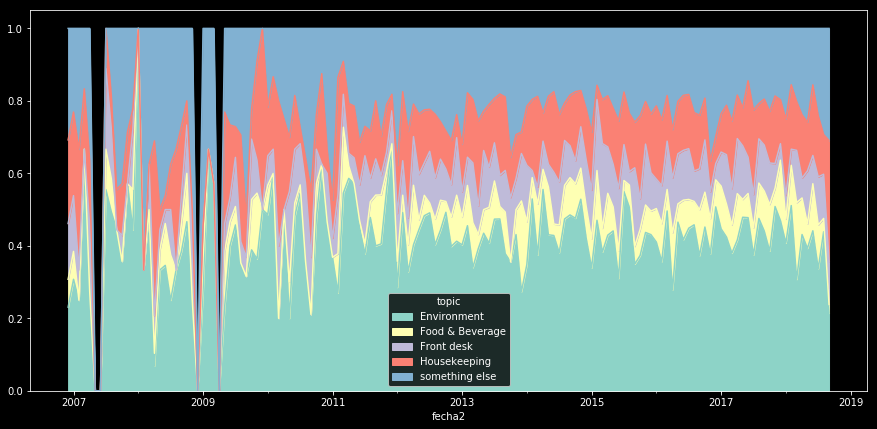

In [65]:
cat.plot(kind='area')

It seems the proportion is keep thought the time. While is very noise. Let's simplify it a bit jsut seen the last year. 

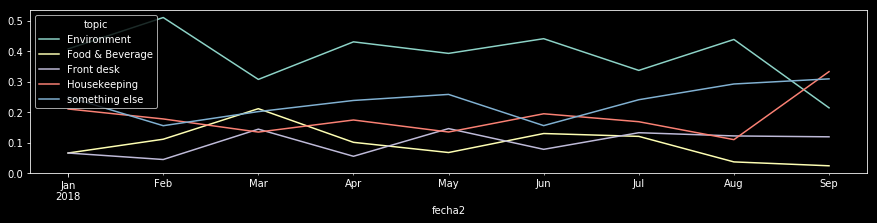

In [68]:
#cat.loc['2014':'2014',:].plot(kind='line',figsize=(12,3))
#cat.loc['2015':'2015',:].plot(kind='line',figsize=(12,3))
#cat.loc['2016':'2016',:].plot(kind='line',figsize=(12,3))
#cat.loc['2017':'2017',:].plot(kind='line',figsize=(12,3))
cat.loc['2018':'2018',:].plot(kind='line',figsize=(15,3))

It seems that something else is becoming more important in comments. But also Housekeeping. Probably should explore that content with other algorithms.

## Other way to classify reviews: LDA

I used word2vec to automatic classify sentences. But there is other options available. We could do some topic modeling. The standard algorithm is Latent Dirichlet Allocations or LDA, which will cluster sentences in a given number of topics. We have several ways to procced here. 

### Regular LDA

Fist we need to determinate the proper numer of topics. As this is a unsupervise technique, we can only use some heuristics. To do so, I will use perplexiy and coherence score.

In [69]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

common_dictionary = Dictionary(text)
common_corpus = [common_dictionary.doc2bow(i) for i in text]
# the model on the corpus.
lda = LdaModel(common_corpus,id2word=common_dictionary, num_topics=20)

In [70]:
lda.print_topics()

[(0,
  u'0.033*"town" + 0.026*"walk" + 0.025*"pool" + 0.022*"beach" + 0.021*"port_douglas" + 0.017*"car" + 0.014*"resort" + 0.013*"short" + 0.013*"around" + 0.012*"room"'),
 (1,
  u'0.056*"spa" + 0.020*"bath" + 0.017*"bbq" + 0.017*"room" + 0.015*"area" + 0.015*"rooftop" + 0.013*"resort" + 0.011*"day" + 0.011*"one" + 0.010*"also"'),
 (2,
  u'0.021*"great" + 0.017*"good" + 0.017*"room" + 0.017*"port_douglas" + 0.015*"town" + 0.015*"food" + 0.014*"wife" + 0.014*"service" + 0.013*"bus" + 0.013*"sea_temple"'),
 (3,
  u'0.055*"apartment" + 0.049*"bedroom" + 0.049*"stayed" + 0.036*"two" + 0.028*"penthouse" + 0.027*"nights" + 0.027*"studio" + 0.026*"spa" + 0.026*"room" + 0.019*"booked"'),
 (4,
  u'0.018*"overall" + 0.018*"stay" + 0.017*"hotel" + 0.014*"place" + 0.014*"return" + 0.013*"modern" + 0.012*"would" + 0.012*"much" + 0.011*"luxury" + 0.010*"good"'),
 (5,
  u'0.044*"sea_temple" + 0.024*"week" + 0.022*"stayed" + 0.020*"night" + 0.019*"great" + 0.017*"restaurant" + 0.015*"recently" + 0.01

### Guided LDA

In [71]:
"""
import guidedlda

X = pd.Series(common_corpus)#guidedlda.datasets.load_data(guidedlda.datasets.NYT)
vocab = common_dictionary#guidedlda.datasets.load_vocab(guidedlda.datasets.NYT)
word2id = dict((v, idx) for idx, v in enumerate(vocab))

#print(X.shape)

#print(X.sum())
# Normal LDA without seeding
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)
model.fit(X)

topic_word = model.topic_word_
n_top_words = 8
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))


# Guided LDA with seed topics.
seed_topic_list = [['game', 'team', 'win', 'player', 'season', 'second', 'victory'],
                   ['percent', 'company', 'market', 'price', 'sell', 'business', 'stock', 'share'],
                   ['music', 'write', 'art', 'book', 'world', 'film'],
                   ['political', 'government', 'leader', 'official', 'state', 'country', 'american', 'case', 'law', 'police', 'charge', 'officer', 'kill', 'arrest', 'lawyer']]

model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)

seed_topics = {}
for t_id, st in enumerate(topic_keywords):
    for word in st:
        seed_topics[word2id[word]] = t_id

model.fit(X, seed_topics=seed_topics, seed_confidence=0.15)

n_top_words = 10
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))
"""

u"\nimport guidedlda\n\nX = pd.Series(common_corpus)#guidedlda.datasets.load_data(guidedlda.datasets.NYT)\nvocab = common_dictionary#guidedlda.datasets.load_vocab(guidedlda.datasets.NYT)\nword2id = dict((v, idx) for idx, v in enumerate(vocab))\n\n#print(X.shape)\n\n#print(X.sum())\n# Normal LDA without seeding\nmodel = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)\nmodel.fit(X)\n\ntopic_word = model.topic_word_\nn_top_words = 8\nfor i, topic_dist in enumerate(topic_word):\n    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]\n    print('Topic {}: {}'.format(i, ' '.join(topic_words)))\n\n\n# Guided LDA with seed topics.\nseed_topic_list = [['game', 'team', 'win', 'player', 'season', 'second', 'victory'],\n                   ['percent', 'company', 'market', 'price', 'sell', 'business', 'stock', 'share'],\n                   ['music', 'write', 'art', 'book', 'world', 'film'],\n                   ['political', 'government', 'leader', 'of

### LDA AND word2Vec

In [72]:
#w=guidedlda.datasets.load_data(guidedlda.datasets.NYT)
#type(w)

# Sentiment analysis

So far I have seen how frequently each section got named, but I don't have idea if it is positive or negative. As most reviews give a high score to the resort we could asumme that most comments are positive, but its not necessary. To do these we could use pre-build polarity sentiment models.

In [73]:
def nltk_sentiment(sentence):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    
    nltk_sentiment = SentimentIntensityAnalyzer()
    score = nltk_sentiment.polarity_scores(sentence)
    return score

In [74]:
nltk_results = [nltk_sentiment(row) for row in dm3.sent]

C:\Users\Cami\Anaconda2\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [75]:
results_df = pd.DataFrame(nltk_results)
#text_df = pd.DataFrame(dataset, columns = ['text'])
dm4 = dm3.join(results_df)

In [76]:
dm4.columns

Index([      u'index',        u'sent',      u'titulo',    u'califica',
        u'comentario',       u'fecha',     u'new_col',    u'keywords',
             u'topic', u'probability',      u'fecha2',    u'compound',
               u'neg',         u'neu',         u'pos'],
      dtype='object')

In [77]:
dm4['fecha2'] = pd.to_datetime(dm4.fecha,format='%d %B %Y')
dmds = dm4.copy()
dmds.index = dmds['fecha2']
dmds.index = pd.to_datetime(dmds.index)
dmds = dmds.sort_values('fecha2')

C:\Users\Cami\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 'fecha2' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """


In [78]:
sen=pd.pivot_table(dmds, values='compound', index=['fecha2'],columns=['topic'], aggfunc=np.mean)
sen=sen.resample(rule='M').mean()

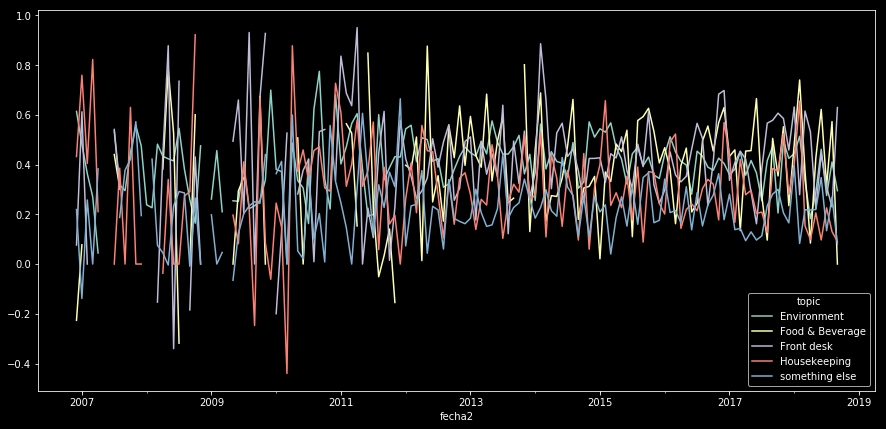

In [79]:
sen.plot(kind='line')

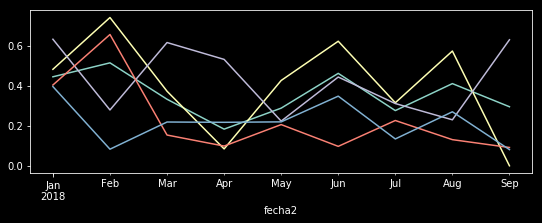

In [80]:
#sen.loc['2014':'2014',:].plot(kind='line', figsize=(12,3))
#sen.loc['2015':'2015',:].plot(kind='line', figsize=(12,3),legend=False)
#sen.loc['2016':'2016',:].plot(kind='line', figsize=(12,3))
#sen.loc['2017':'2017',:].plot(kind='line', figsize=(12,3),legend=False)
sen.loc['2018':'2018',:].plot(kind='line', figsize=(9,3),legend=False)